In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
warnings.filterwarnings("ignore")


In [2]:
#load some data
base_url = "https://raw.githubusercontent.com/NocturneBear/NBA-Data-2010-2024/main/"
files = [
    "regular_season_box_scores_2010_2024_part_1.csv",
    "regular_season_box_scores_2010_2024_part_2.csv",
    "regular_season_box_scores_2010_2024_part_3.csv",
    "play_off_box_scores_2010_2024.csv"
]
dfs = [pd.read_csv(base_url + f) for f in files]

playoffs = dfs[3]
playoffs['game_date'] = pd.to_datetime(playoffs['game_date'], errors='coerce')

rs1 = dfs[0]
rs2 = dfs[1]
rs3 = dfs[2]

In [3]:
rs1

,season_year,game_date,gameId,matchup,teamId,teamCity,teamName,teamTricode,teamSlug,personId,...,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints
0,2010-11,2010-11-10,21000112,NJN @ CLE,1610612751,New Jersey,Nets,NJN,nets,693,...,0,0,0,0,0,0,0,0,0,-4
1,2010-11,2010-11-17,21000165,NJN @ UTA,1610612751,New Jersey,Nets,NJN,nets,693,...,0,0,0,0,0,0,0,0,0,0
2,2010-11,2010-11-27,21000237,NJN @ PHI,1610612751,New Jersey,Nets,NJN,nets,693,...,0,0,0,0,0,0,0,0,0,0
3,2010-11,2010-12-12,21000351,NJN vs. LAL,1610612751,New Jersey,Nets,NJN,nets,693,...,0,0,0,0,0,0,0,0,0,0
4,2010-11,2010-10-29,21000020,NJN vs. SAC,1610612751,New Jersey,Nets,NJN,nets,693,...,0,1,1,1,0,0,1,1,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141488,2010-11,2010-12-17,21000389,HOU vs. MEM,1610612745,Houston,Rockets,HOU,rockets,2449,...,3,6,9,2,0,1,6,2,23,39
141489,2011-12,2012-03-02,21100534,HOU vs. DEN,1610612745,Houston,Rockets,HOU,rockets,2449,...,1,3,4,1,0,0,2,1,13,-4
141490,2010-11,2010-11-17,21000164,HOU @ OKC,1610612745,Houston,Rockets,HOU,rockets,2449,...,2,6,8,0,0,0,3,3,26,-8
141491,2011-12,2012-02-08,21100383,HOU @ POR,1610612745,Houston,Rockets,HOU,rockets,2449,...,1,1,2,2,0,1,4,3,12,-5


In [4]:
regular = pd.concat([rs1, rs2, rs3], ignore_index=True)
regular['is_playoff'] = 0
playoffs['is_playoff'] = 1

df = pd.concat([regular, playoffs], ignore_index=True)

#format
df.drop(columns=['jerseyNum', 'comment', 'position', 'matchup'], inplace=True)
df['game_date'] = pd.to_datetime(df['game_date'], errors='coerce')

def convert_minutes(min_str):
    try:
        if pd.isna(min_str): return 0
        parts = min_str.split(':')
        return int(parts[0]) + int(parts[1]) / 60 if len(parts) == 2 else 0
    except: return 0

df['minutes_played'] = df['minutes'].apply(convert_minutes)
df.drop(columns=['minutes'], inplace=True)
df['season'] = df['season_year'].str[:4].astype(int)

#data aggs
agg = df.groupby(['personId', 'personName', 'game_date', 'is_playoff']).agg({
    'gameId': 'count',
    'minutes_played': 'sum',
    'points': 'sum',
    'assists': 'sum',
    'reboundsTotal': 'sum',
    'fieldGoalsMade': 'sum',
    'fieldGoalsAttempted': 'sum',
    'threePointersMade': 'sum',
    'freeThrowsMade': 'sum',
    'turnovers': 'sum',
    'plusMinusPoints': 'sum'
}).rename(columns={'gameId': 'games_played'}).reset_index().sort_values('game_date')

agg['ppm'] = (agg['points'] / agg['minutes_played']).dropna()
agg = agg[agg.minutes_played > 0]


# pivoted = agg.pivot_table(index=['personId', 'personName', 'season'], columns='is_playoff',
#                           values=['points', 'minutes_played', 'assists', 'reboundsTotal'], aggfunc='sum')
# pivoted.columns = ['_'.join(map(str, col)) for col in pivoted.columns]
# pivoted = pivoted.dropna()

# #per min stats
# pivoted['ppm_regular'] = pivoted['points_0'] / pivoted['minutes_played_0']
# pivoted['ppm_playoff'] = pivoted['points_1'] / pivoted['minutes_played_1']
# pivoted['residual_ppm'] = pivoted['ppm_playoff'] - pivoted['ppm_regular']


# #resids
# residual_series = pivoted.sort_values(['season', 'personId'])['residual_ppm'].reset_index(drop=True).dropna()

In [5]:
agg

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,fieldGoalsAttempted,threePointersMade,freeThrowsMade,turnovers,plusMinusPoints,ppm
0,255,Grant Hill,2010-10-26,0,1,26.083333,4,1,1,2,4,0,0,3,-8,0.153355
78571,101236,Chuck Hayes,2010-10-26,0,1,14.816667,0,1,0,0,0,0,0,0,-9,0.000000
10294,1889,Andre Miller,2010-10-26,0,1,26.700000,10,9,2,4,8,0,2,3,14,0.374532
76536,101177,Fabricio Oberto,2010-10-26,0,1,3.050000,0,0,1,0,1,0,0,1,0,0.000000
9854,1885,Lamar Odom,2010-10-26,0,1,32.900000,14,1,10,7,10,0,0,4,11,0.425532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443407,1630639,AJ Lawson,2024-06-17,1,1,2.616667,0,0,0,0,0,0,0,0,3,0.000000
392057,1629052,Oshae Brissett,2024-06-17,1,1,0.650000,0,0,0,0,0,0,0,0,0,0.000000
369504,1628436,Luke Kornet,2024-06-17,1,1,2.033333,0,0,1,0,0,0,0,0,-2,0.000000
338596,1627759,Jaylen Brown,2024-06-17,1,1,44.250000,21,6,8,7,23,2,5,1,20,0.474576


In [40]:
agg[agg.ppm.isna()]

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,fieldGoalsAttempted,threePointersMade,freeThrowsMade,turnovers,plusMinusPoints,ppm


In [98]:
agg

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,fieldGoalsAttempted,threePointersMade,freeThrowsMade,turnovers,plusMinusPoints,ppm
0,255,Grant Hill,2010-10-26,0,1,26.083333,4,1,1,2,4,0,0,3,-8,0.153355
78571,101236,Chuck Hayes,2010-10-26,0,1,14.816667,0,1,0,0,0,0,0,0,-9,0.000000
10294,1889,Andre Miller,2010-10-26,0,1,26.700000,10,9,2,4,8,0,2,3,14,0.374532
76536,101177,Fabricio Oberto,2010-10-26,0,1,3.050000,0,0,1,0,1,0,0,1,0,0.000000
9854,1885,Lamar Odom,2010-10-26,0,1,32.900000,14,1,10,7,10,0,0,4,11,0.425532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443407,1630639,AJ Lawson,2024-06-17,1,1,2.616667,0,0,0,0,0,0,0,0,3,0.000000
392057,1629052,Oshae Brissett,2024-06-17,1,1,0.650000,0,0,0,0,0,0,0,0,0,0.000000
369504,1628436,Luke Kornet,2024-06-17,1,1,2.033333,0,0,1,0,0,0,0,0,-2,0.000000
338596,1627759,Jaylen Brown,2024-06-17,1,1,44.250000,21,6,8,7,23,2,5,1,20,0.474576


In [99]:
agg['points_lagged'] = agg.groupby('personId')['points'].shift(1)

In [103]:
import statsmodels.api as sm

In [105]:
agg_dropped= agg.dropna(subset = ['points_lagged', 'points'])

In [107]:

X = agg_dropped[['points_lagged']]
y = agg_dropped['points']


X_with_const = sm.add_constant(X) 

# Fit OLS model
model = sm.OLS(y, X_with_const)
results = model.fit()

# Print summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                 1.946e+05
Date:                Mon, 31 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:09:04   Log-Likelihood:            -1.2460e+06
No. Observations:              374379   AIC:                         2.492e+06
Df Residuals:                  374377   BIC:                         2.492e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.1796      0.017    241.443

In [133]:
from pmdarima import auto_arima

In [172]:
unique_players = agg.personName.unique()

bruh = []

for player in unique_players:
    sub = agg[agg.personName == player].query('minutes_played > 5')
    
    if len(sub) < 500:
        continue

    bruh.append((sub.ppm.diff().mean(), player))

bruh.sort()

for i in range(10):
    ok = bruh[i][1]

    sub = agg[agg.personName == ok].query('minutes_played > 5')

    # Plot absolute changes
    plt.figure(figsize=(10, 5))
    plt.plot(sub['ppm'], color='red', label='PPM Changes')
    plt.xlabel("Time")
    plt.ylabel("Change in PPM")
    plt.title("Volatility Clustering in PPM ({})".format(ok))
    plt.legend()
    plt.show()

KeyboardInterrupt: 

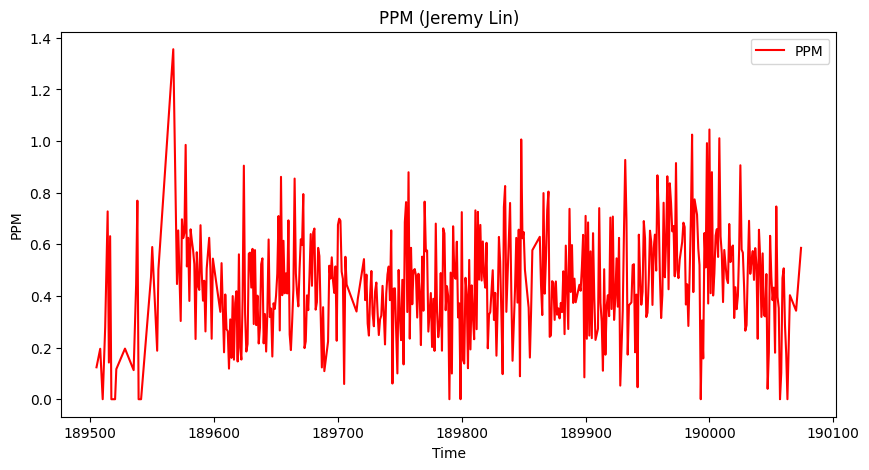

In [176]:
ok = 'Jeremy Lin'
sub = agg[agg.personName == ok].query('minutes_played > 5')

plt.figure(figsize=(10, 5))
plt.plot(sub['ppm'], color='red', label='PPM')
plt.xlabel("Time")
plt.ylabel("PPM")
plt.title("PPM ({})".format(ok))
plt.legend()
plt.show()

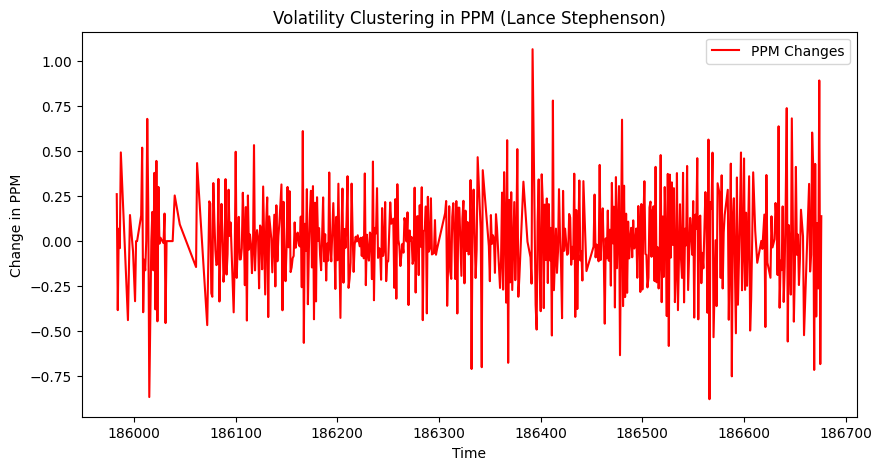

In [ ]:
ok = 'Lance Stephenson'
sub = agg[agg.personName == ok].query('minutes_played > 5')

# Plot absolute changes
plt.figure(figsize=(10, 5))
plt.plot(sub['ppm'].diff(), color='red', label='PPM Changes')
plt.xlabel("Time")
plt.ylabel("Change in PPM")
plt.title("Volatility Clustering in PPM ({})".format(ok))
plt.legend()
plt.show()

In [ ]:
unique_players = agg.personName.unique()

filtered_out_players = []

print(len(unique_players))

player_predictions = []

for player in unique_players:
    sub = agg[agg.personName == player].query('minutes_played > 5')
    
    if len(sub) < 200:
        filtered_out_players.append(player)
        continue

    # Plot absolute changes
    plt.figure(figsize=(10, 5))
    plt.plot(sub['ppm'], color='red', label='PPM')
    plt.xlabel("Time")
    plt.ylabel("PPM")
    plt.title("PPM ({})".format(player))
    plt.legend()
    plt.show()

In [6]:
agg_train = agg[agg['game_date'].dt.year < 2024]  # All data before 2024
agg_test = agg[agg['game_date'].dt.year == 2024]  # All games in 2024

In [ ]:
unique_players = agg.personName.unique()

filtered_out_players = []

print(len(unique_players))

player_predictions = []

player_models = {}

for player in unique_players:
    sub = agg[agg.personName == player].query('minutes_played > 20')
    
    if len(sub) < 50:
        filtered_out_players.append(player)
        continue

    # adf_stat, adf_p = adfuller(sub.ppm)[:2]
    # # print(player, len(sub), f"\nADF Test:\nStat = {adf_stat:.4f}, p = {adf_p:.4f}")

    # if adf_p > 0.05:
    #     # filtered out
    #     filtered_out_players.append(player)
    #     continue

    sub_train_size = len(sub) * 8 // 10
    sub_test_size = len(sub) - sub_train_size
    
    sub_train = sub[:sub_train_size].reset_index()
    sub_test = sub[sub_train_size:].reset_index()

    # auto_model = auto_arima(sub.ppm, 
    #                     start_p=0, max_p=5,   # Range for AR term
    #                     start_q=0, max_q=5,   # Range for MA term
    #                     seasonal=False,       # ARMA is non-seasonal
    #                     stepwise=True,        # Stepwise search
    #                     trace=True)           # Print model selection process

    # p, q, d = 1, 1, 0

    # p, q, d = auto_model.order

    # model = ARIMA(sub_train.reset_index()['ppm'], order = (p, q, d))

    # model = arch_model(sub, vol = 'Garch', p = p, q = q, mean = 'Constant')

    # fitted_model = model.fit(disp = 'off')

    # fitted_model = model.fit()

    # player_models[player] = fitted_model

    # predictions = fitted_model.predict(start = max(p, q), end = len(sub) - 1, dynamic = False)

    # **Step 3: Forecasting on Test Set (Using Prior Test Data)**
    predictions = []
    residuals = []
    history = list(sub_train['ppm'])  # Start with training data

    for actual_value in sub_test['ppm']:  
        # auto_model = auto_arima(sub.ppm, 
        #                 start_p=0, max_p=5,   # Range for AR term
        #                 start_q=0, max_q=5,   # Range for MA term
        #                 seasonal=True,       # ARMA is non-seasonal
        #                 stepwise=True,        # Stepwise search
        #                 trace=False)           # Print model selection process
        
        # p, d, q = auto_model.order

        p, d, q = 1, 1, 1

        model = ARIMA(history, order=(p, d, q))  # Train on expanding data
        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=1)[0]  # Predict next step

        # forecast = np.mean(history[-3:])
        
        predictions.append(forecast)  # Store prediction
        history.append(actual_value)  # Update history with actual test value
        residuals.append((actual_value - forecast) ** 2)

    plt.figure(figsize=(8, 5))
    plot_acf(residuals, lags=10)  # Adjust lags as needed
    plt.xlabel("Lags")
    plt.ylabel("Autocorrelation")
    plt.title("Autocorrelation Function (ACF) of PPM Squared Residuals")
    plt.show()

    # # **Step 4: Store Predictions & Evaluate**
    # # test['predicted_ppm'] = predictions
    
    new_sub = sub_test.copy().reset_index(drop=True)
    new_sub['predicted_ppm'] = predictions
    new_sub = new_sub.dropna(subset=['predicted_ppm'])

    player_predictions.append(new_sub)

    # print(player, len(sub), adf_p, sum(new_sub.ppm.isna()), sum(new_sub.predicted_ppm.isna()))
    # # print(new_sub[['ppm', 'predicted_ppm']])
    
    print(
        player,
        r2_score(new_sub['ppm'], new_sub['predicted_ppm']),
        np.corrcoef(new_sub['ppm'], new_sub['predicted_ppm'])[0][1]
    )
    # print(player, np.corrcoef(new_sub['ppm'], new_sub['predicted_ppm'])[0][1])
    # valid_data = new_sub.dropna(subset=['ppm', 'predicted_ppm'])

    # # Scatter plot
    # plt.figure(figsize=(6, 6))
    # plt.scatter(valid_data['ppm'], valid_data['predicted_ppm'], alpha=0.6, color='blue')

    # # Add a reference y=x line (ideal predictions)
    # plt.plot(valid_data['ppm'], valid_data['ppm'], linestyle="--", color="red", label="Perfect Fit")

    # # Labels & title
    # plt.xlabel("Actual PPM")
    # plt.ylabel("Predicted PPM")
    # plt.title(f"Prediction Scatter Plot for {player}")
    # plt.legend()

    # # Show plot
    # plt.show()

In [ ]:
# all_predictions = []
# all_real = []

# for player, model in player_models.items():
#     # Filter test set for the current player
#     player_total = agg[agg['personName'] == player].reset_index()
#     player_train_size = sum(agg_train['personName'] == player)
#     player_test_size = len(player_total) - player_train_size

#     # Ensure the test set isn't empty
#     if player_test_size < 20:
#         continue

#     # Generate predictions for test set
#     predictions = model.predict(start=, end=len(player_test)-1, dynamic=False)

#     # Compute R² score
#     r2 = r2_score(player_test['ppm'], predictions)
#     # r2_scores[player] = r2

#     print(f"Player: {player}, R²: {r2:.4f}", np.corrcoef(player_test['ppm'], predictions)[0][1])

#     all_predictions += list(predictions)
#     all_real += list(player_test['ppm'])

Player: Robin Lopez, R²: -1.2171 0.4242098596174488
Player: Nicolas Batum, R²: -2.3961 -0.12008037666172053
Player: LeBron James, R²: -0.1745 0.40880009639766735
Player: Ish Smith, R²: -1.6080 -0.33401462053153586
Player: Derrick Rose, R²: -3.2672 0.3960358706850093
Player: DeAndre Jordan, R²: -0.1908 -0.1893041727256147
Player: James Harden, R²: -0.2042 0.07572829427035942
Player: Russell Westbrook, R²: -0.6936 -0.031040579595804342
Player: Kevin Love, R²: -0.3185 -0.15290726493526507
Player: Brook Lopez, R²: -1.0303 -0.09242273295976722
Player: Danilo Gallinari, R²: -0.2866 -0.16151335430367258
Player: Eric Gordon, R²: -1.7188 -0.11818405011131061
Player: Garrett Temple, R²: -0.3063 -0.19087221858288037
Player: Paul George, R²: -2.0408 -0.1180409725919831
Player: Gordon Hayward, R²: -0.1907 0.15177022630852907
Player: Stephen Curry, R²: -0.9333 -0.10617638225684446
Player: Jrue Holiday, R²: -0.1884 0.0131241103929784
Player: DeMar DeRozan, R²: -1.7246 0.1671021753556051
Player: Taj G

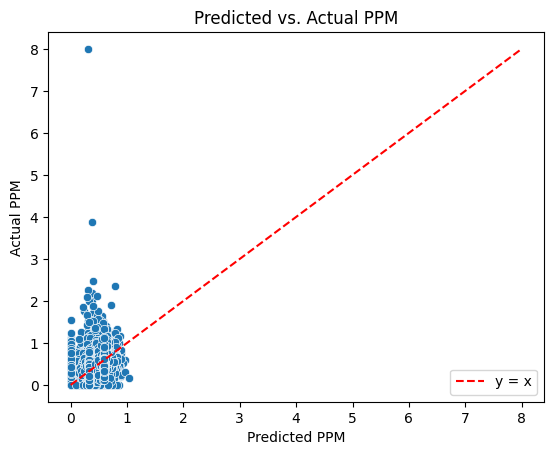

In [194]:
sns.scatterplot(x = all_predictions, y = all_real)
min_val = min(all_real)  # Get minimum value
max_val = max(all_real)  # Get maximum value
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="y = x")

# Labels & title
plt.xlabel("Predicted PPM")
plt.ylabel("Actual PPM")
plt.title("Predicted vs. Actual PPM")
plt.legend()


In [228]:
df_full = pd.concat(player_predictions)

In [229]:
import seaborn as sns

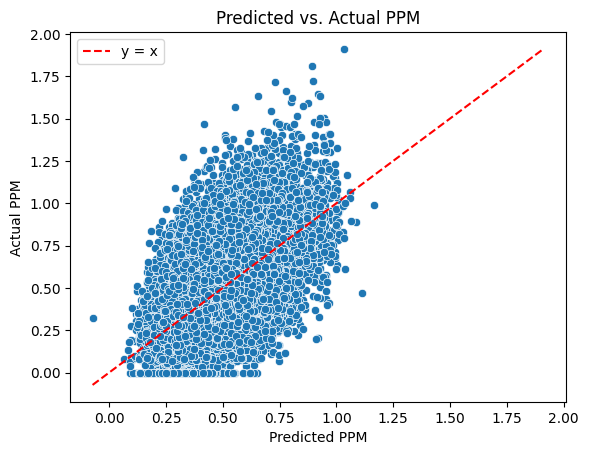

In [230]:
sns.scatterplot(df_full, x = 'predicted_ppm', y = 'ppm')
min_val = min(df_full[['predicted_ppm', 'ppm']].min())  # Get minimum value
max_val = max(df_full[['predicted_ppm', 'ppm']].max())  # Get maximum value
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="y = x")

# Labels & title
plt.xlabel("Predicted PPM")
plt.ylabel("Actual PPM")
plt.title("Predicted vs. Actual PPM")
plt.legend()


In [231]:
playoff_df_full = df_full[df_full['is_playoff'] == 1]
r2_score(playoff_df_full.ppm, playoff_df_full.predicted_ppm)

0.2888902742312721

In [232]:
r2_score(df_full.ppm, df_full.predicted_ppm)

0.32508368000675525

In [139]:
df_full[['predicted_ppm', 'ppm']].corr()

,predicted_ppm,ppm
predicted_ppm,1.000000,0.557156
ppm,0.557156,1.000000


In [123]:
df_full

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,fieldGoalsAttempted,threePointersMade,freeThrowsMade,turnovers,plusMinusPoints,ppm,points_lagged,predicted_ppm
1,255,Grant Hill,2010-10-28,0,1,28.750000,9,2,12,3,7,0,3,2,4,0.313043,4.0,0.153355
2,255,Grant Hill,2010-10-29,0,1,33.916667,21,2,3,10,17,0,1,0,-2,0.619165,9.0,0.227072
3,255,Grant Hill,2010-11-03,0,1,33.433333,15,1,8,5,11,1,4,0,5,0.448654,21.0,0.341718
4,255,Grant Hill,2010-11-05,0,1,23.533333,2,4,6,1,9,0,0,3,-3,0.084986,15.0,0.383985
5,255,Grant Hill,2010-11-07,0,1,22.950000,14,2,6,5,10,0,4,3,-10,0.610022,2.0,0.348629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,1641871,Duop Reath,2024-03-22,0,1,26.683333,13,2,3,5,10,2,1,3,-14,0.487196,8.0,0.533675
21,1641871,Duop Reath,2024-03-23,0,1,26.333333,24,2,8,9,14,3,3,2,9,0.911392,13.0,0.531107
22,1641871,Duop Reath,2024-03-25,0,1,23.983333,8,0,4,3,8,0,2,0,-15,0.333565,24.0,0.532222
23,1641871,Duop Reath,2024-03-27,0,1,30.216667,13,5,5,6,12,1,0,1,-16,0.430226,8.0,0.553525


In [234]:
agg

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,fieldGoalsAttempted,threePointersMade,freeThrowsMade,turnovers,plusMinusPoints,ppm,points_lagged
0,255,Grant Hill,2010-10-26,0,1,26.083333,4,1,1,2,4,0,0,3,-8,0.153355,NaN
78571,101236,Chuck Hayes,2010-10-26,0,1,14.816667,0,1,0,0,0,0,0,0,-9,0.000000,NaN
10294,1889,Andre Miller,2010-10-26,0,1,26.700000,10,9,2,4,8,0,2,3,14,0.374532,NaN
76536,101177,Fabricio Oberto,2010-10-26,0,1,3.050000,0,0,1,0,1,0,0,1,0,0.000000,NaN
9854,1885,Lamar Odom,2010-10-26,0,1,32.900000,14,1,10,7,10,0,0,4,11,0.425532,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443407,1630639,AJ Lawson,2024-06-17,1,1,2.616667,0,0,0,0,0,0,0,0,3,0.000000,2.0
392057,1629052,Oshae Brissett,2024-06-17,1,1,0.650000,0,0,0,0,0,0,0,0,0,0.000000,7.0
369504,1628436,Luke Kornet,2024-06-17,1,1,2.033333,0,0,1,0,0,0,0,0,-2,0.000000,0.0
338596,1627759,Jaylen Brown,2024-06-17,1,1,44.250000,21,6,8,7,23,2,5,1,20,0.474576,10.0


In [283]:
year = 2023

before_2023 = agg[agg['game_date'].dt.year < year].sort_values('game_date')
after_2023 = agg[agg['game_date'].dt.year >= year].sort_values('game_date')

playoffs_before_2023 = playoffs[playoffs['game_date'].dt.year < year].sort_values(by = ['game_date', 'gameId'])
playoffs_after_2023 = playoffs[playoffs['game_date'].dt.year >= year].sort_values(by = ['game_date', 'gameId'])

In [294]:
unique_game_ids = playoffs_after_2023['gameId'].unique()

player_histories = {}
minutes_played_histories = {}

def add_entry_to_player_history(entry):
    if not entry.personName in player_histories:
        player_histories[entry.personName] = []
        minutes_played_histories[entry.personName] = []
    
    if entry.minutes_played > 10:
        player_histories[entry.personName].append(entry.ppm)
    
    minutes_played_histories[entry.personName].append(entry.minutes_played)

def get_player_predicted_points(entry):
    player_name = entry.personName

    if not player_name in player_histories:
        # first time they're playing
        return 0
    
    if len(player_histories[player_name]) < 40:
        if len(player_histories[player_name]) == 0:
            return 0
        mean_ppm = np.mean(player_histories[player_name])
        mean_minutes_played = np.mean(minutes_played_histories[player_name])
        return mean_ppm * mean_minutes_played

    p, d, q = 1, 1, 1

    model = ARIMA(history, order=(p, d, q))  # Train on expanding data
    fitted_model = model.fit()
    forecast_ppm = fitted_model.forecast(steps=1)[0]  # Predict next step

    mean_minutes_played = np.mean(minutes_played_histories[player_name][-10:])

    return forecast_ppm * mean_minutes_played

for entry in before_2023.itertuples():
    add_entry_to_player_history(entry)

print("finished initializing before 2023 games")

ptr = 0

real_results = []
predicted_results = []

all_real_points = []
all_expected_points = []

for game_id in unique_game_ids:
    entries = playoffs_after_2023[playoffs_after_2023['gameId'] == game_id]

    while ptr < len(after_2023) and after_2023.iloc[ptr].game_date < entries.iloc[0].game_date:
        add_entry_to_player_history(after_2023.iloc[ptr])
        ptr += 1

    expected_points = {}
    actual_points = {}

    teams = []

    for entry in entries.itertuples():
        team_name = entry.teamCity + ' ' + entry.teamName
        teams.append(team_name)

        if not team_name in expected_points:
            expected_points[team_name] = 0
            actual_points[team_name] = 0
        expected_points[team_name] += get_player_predicted_points(entry)
        actual_points[team_name] += entry.points

    all_real_points.append(actual_points)
    all_expected_points.append(expected_points)

    teams = np.unique(teams)
    assert(len(teams) == 2)

    real_results.append(1 if actual_points[teams[0]] > actual_points[teams[1]] else 0)
    predicted_results.append(1 if expected_points[teams[0]] > expected_points[teams[1]] else 0)

    if len(real_results) % (len(unique_game_ids) // 10) == 0:
        print(len(real_results), len(unique_game_ids))

finished initializing before 2023 games
16 166
32 166
48 166
64 166
80 166
96 166
112 166
128 166
144 166
160 166


In [295]:
for i in range(10):
    print(all_real_points[i], all_expected_points[i])
    print(real_results[i], predicted_results[i])

{'Atlanta Hawks': 99, 'Boston Celtics': 112} {'Atlanta Hawks': 161.10196285287515, 'Boston Celtics': 163.52044904182043}
0 0
{'Brooklyn Nets': 101, 'Philadelphia 76ers': 121} {'Brooklyn Nets': 156.29729214852563, 'Philadelphia 76ers': 168.41387883031015}
0 0
{'New York Knicks': 101, 'Cleveland Cavaliers': 97} {'New York Knicks': 174.0995673960795, 'Cleveland Cavaliers': 161.10352919867393}
0 0
{'Sacramento Kings': 126, 'Golden State Warriors': 123} {'Sacramento Kings': 141.94246534467078, 'Golden State Warriors': 158.52395460906203}
0 1
{'Miami Heat': 130, 'Milwaukee Bucks': 117} {'Miami Heat': 156.12133248991773, 'Milwaukee Bucks': 165.0633834609324}
1 0
{'Denver Nuggets': 109, 'Minnesota Timberwolves': 80} {'Denver Nuggets': 167.70586052454985, 'Minnesota Timberwolves': 136.80404834585016}
1 1
{'Los Angeles Lakers': 128, 'Memphis Grizzlies': 112} {'Los Angeles Lakers': 167.85430814014782, 'Memphis Grizzlies': 150.54755048677166}
1 1
{'Phoenix Suns': 110, 'LA Clippers': 115} {'Phoenix

In [297]:
acc = sum(np.array(real_results) == np.array(predicted_results)) / len(real_results)
acc

0.572289156626506

In [298]:
(acc - 0.5) / np.sqrt(0.5 * 0.5 / len(real_results))

1.862761261695199

In [243]:
playoffs_before_2023

,season_year,game_date,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,personId,personName,...,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints
6725,2010-11,2011-04-16,41000101,1610612741,Chicago,Bulls,CHI,bulls,703,Kurt Thomas,...,3,1,4,2,1,0,0,2,6,11
6874,2010-11,2011-04-16,41000101,1610612741,Chicago,Bulls,CHI,bulls,2430,Carlos Boozer,...,1,5,6,0,0,1,4,5,12,-5
6875,2010-11,2011-04-16,41000101,1610612741,Chicago,Bulls,CHI,bulls,2446,Rasual Butler,...,0,0,0,0,0,0,0,0,0,0
6925,2010-11,2011-04-16,41000101,1610612741,Chicago,Bulls,CHI,bulls,2586,Keith Bogans,...,0,3,3,0,0,0,0,1,0,-11
6943,2010-11,2011-04-16,41000101,1610612741,Chicago,Bulls,CHI,bulls,2594,Kyle Korver,...,0,2,2,3,0,1,2,2,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24322,2021-22,2022-06-16,42100406,1610612744,Golden State,Warriors,GSW,warriors,1627814,Damion Lee,...,0,0,0,0,0,0,0,0,0,0
24439,2021-22,2022-06-16,42100406,1610612744,Golden State,Warriors,GSW,warriors,1629308,Juan Toscano-Anderson,...,0,0,0,0,0,0,0,0,0,0
24470,2021-22,2022-06-16,42100406,1610612744,Golden State,Warriors,GSW,warriors,1629673,Jordan Poole,...,1,2,3,2,0,0,0,3,15,11
24498,2021-22,2022-06-16,42100406,1610612744,Golden State,Warriors,GSW,warriors,1630228,Jonathan Kuminga,...,0,0,0,0,0,0,0,0,0,0


In [62]:
sum(new_sub.predicted_ppm.isna())

19

In [71]:
new_sub[['ppm', 'predicted_ppm']].iloc[100:]

,ppm,predicted_ppm
100,0.320095,0.108870
101,0.067077,0.341619
102,0.404774,0.141464
103,0.360065,0.166995
104,0.213958,0.309778
105,0.293542,0.324244
106,0.484740,0.420191
107,0.283186,NaN
108,0.422337,0.207359
109,0.397112,0.414865


In [66]:
new_sub

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,fieldGoalsAttempted,threePointersMade,freeThrowsMade,turnovers,plusMinusPoints,ppm,predicted_ppm
0,255,Grant Hill,2010-10-28,0,1,28.750000,9,2,12,3,7,0,3,2,4,0.313043,NaN
1,255,Grant Hill,2010-10-29,0,1,33.916667,21,2,3,10,17,0,1,0,-2,0.619165,NaN
2,255,Grant Hill,2010-11-03,0,1,33.433333,15,1,8,5,11,1,4,0,5,0.448654,0.472732
3,255,Grant Hill,2010-11-05,0,1,23.533333,2,4,6,1,9,0,0,3,-3,0.084986,0.834174
4,255,Grant Hill,2010-11-07,0,1,22.950000,14,2,6,5,10,0,4,3,-10,0.610022,0.672185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,255,Grant Hill,2013-03-26,0,1,5.600000,0,0,0,0,0,0,0,0,-9,0.000000,0.398854
154,255,Grant Hill,2013-03-30,0,1,13.833333,2,0,2,1,3,0,0,2,-1,0.144578,0.343035
155,255,Grant Hill,2013-04-13,0,1,11.466667,5,0,1,2,3,1,0,0,5,0.436047,0.320330
156,255,Grant Hill,2013-04-16,0,1,6.450000,2,0,2,1,3,0,0,0,-8,0.310078,0.392646


In [ ]:
player_predictions_df = pd.concat(player_predictions).sort_values('game_date')
player_predictions_df

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,fieldGoalsAttempted,threePointersMade,freeThrowsMade,turnovers,plusMinusPoints,ppm,predicted_ppm
1,255,Grant Hill,2010-10-28,0,1,28.750000,9,2,12,3,7,0,3,2,4,0.313043,0.230032
2,255,Grant Hill,2010-10-29,0,1,33.916667,21,2,3,10,17,0,1,0,-2,0.619165,0.472732
3,255,Grant Hill,2010-11-03,0,1,33.433333,15,1,8,5,11,1,4,0,5,0.448654,0.834174
4,255,Grant Hill,2010-11-05,0,1,23.533333,2,4,6,1,9,0,0,3,-3,0.084986,0.672185
5,255,Grant Hill,2010-11-07,0,1,22.950000,14,2,6,5,10,0,4,3,-10,0.610022,0.228998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455348,1641998,Trey Jemison,2024-04-06,0,1,33.466667,5,2,7,2,6,0,1,3,-17,0.149402,0.674958
455349,1641998,Trey Jemison,2024-04-09,0,1,30.166667,14,2,9,6,14,0,2,1,-4,0.464088,0.173962
455350,1641998,Trey Jemison,2024-04-10,0,1,35.933333,4,3,9,2,7,0,0,1,-17,0.111317,0.450410
455351,1641998,Trey Jemison,2024-04-12,0,1,35.416667,6,0,5,3,4,0,0,1,8,0.169412,-0.027863


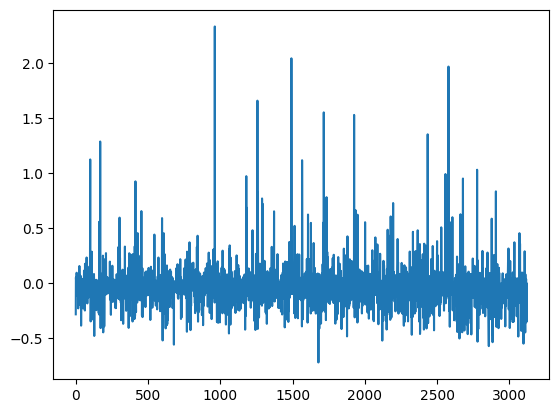

In [19]:
plt.plot(residual_series)

In [21]:
#adf tests
adf_stat, adf_p = adfuller(residual_series)[:2]
print(f"\nADF Test:\nStat = {adf_stat:.4f}, p = {adf_p:.4f}")

#stationary :0


ADF Test:
Stat = -53.5442, p = 0.0000


In [26]:




#diff
series_diff = residual_series.diff().dropna() if adf_p > 0.05 else residual_series

# armima pqd
best_aic = np.inf
best_order = None
for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(residual_series, order=(p, 1, q)).fit()
            if model.aic < best_aic:
                best_aic, best_order, best_model = model.aic, (p, 1, q), model
        except:
            continue

print(f"\nBest ARIMA order: {best_order} with AIC: {best_aic:.2f}")




Best ARIMA order: (0, 1, 1) with AIC: -1600.38


In [30]:
#garch lol
returns = series_diff.pct_change().replace([np.inf, -np.inf], np.nan).dropna() * 100
garch = arch_model(returns, vol='GARCH', p=1, q=1)
garch_fitted = garch.fit(disp='off')
print("\nGARCH Summary:\n", garch_fitted.summary())




GARCH Summary:
                      Constant Mean - GARCH Model Results                      
Dep. Variable:           residual_ppm   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -28255.1
Distribution:                  Normal   AIC:                           56518.2
Method:            Maximum Likelihood   BIC:                           56542.1
                                        No. Observations:                 2963
Date:                Mon, Mar 31 2025   Df Residuals:                     2962
Time:                        02:39:05   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu           -58.9071     61.641     -0.956 

In [31]:
#lasso garch x (prof loves this)
X = pivoted[['assists_0', 'reboundsTotal_0']].reset_index(drop=True).loc[series_diff.index]
y = returns.loc[X.index]
lasso = LassoCV(cv=5).fit(X, y)
selected = np.where(lasso.coef_ != 0)[0]
selected_features = X.columns[selected]
print(f"\nSelected features by Lasso: {selected_features.tolist()}")

exog = X.iloc[:, selected]
garchx = arch_model(y, x=exog, vol='GARCH', p=1, q=1)
garchx_fitted = garchx.fit(disp='off')
print("\nGARCH-X Summary:\n", garchx_fitted.summary())

# r2
r2_arima = r2_score(residual_series[1:], best_model.predict(start=1, end=len(residual_series)-1))
print(f"\nARIMA R2: {r2_arima:.4f}")

# arima fit
plt.figure(figsize=(12, 6))
plt.plot(residual_series, label='Observed residual PPM')
plt.plot(best_model.predict(start=1, end=len(residual_series)-1), label='ARIMA Predicted')
plt.title("ARIMA Fit on Residual PPM (Playoff - Regular)")
plt.legend()
plt.tight_layout()
plt.show()

KeyError: '[0, 757] not in index'